In [2]:

import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
from google.colab import files
uploaded = files.upload()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Saving email.csv to email.csv


In [3]:
df = pd.read_csv('/content/email.csv')

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df = df[['Category', 'Message']]

In [6]:
# Encode labels
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

In [7]:
# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Message'] = df['Message'].apply(preprocess_text)

In [8]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Message'])
sequences = tokenizer.texts_to_sequences(df['Message'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [9]:
# Save tokenizer for later use
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Model building and training


In [10]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Category'], test_size=0.2, random_state=42)

In [11]:
# Define model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [12]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
70/70 [==============================] - 25s 287ms/step - loss: 0.2619 - accuracy: 0.9114 - val_loss: 0.0864 - val_accuracy: 0.9776
Epoch 2/10
70/70 [==============================] - 18s 260ms/step - loss: 0.0488 - accuracy: 0.9870 - val_loss: 0.0504 - val_accuracy: 0.9857
Epoch 3/10
70/70 [==============================] - 19s 271ms/step - loss: 0.0250 - accuracy: 0.9935 - val_loss: 0.0437 - val_accuracy: 0.9892
Epoch 4/10
70/70 [==============================] - 17s 250ms/step - loss: 0.0166 - accuracy: 0.9960 - val_loss: 0.0452 - val_accuracy: 0.9892
Epoch 5/10
70/70 [==============================] - 18s 258ms/step - loss: 0.0117 - accuracy: 0.9978 - val_loss: 0.0449 - val_accuracy: 0.9892
Epoch 6/10
70/70 [==============================] - 19s 278ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0481 - val_accuracy: 0.9865
Epoch 7/10
70/70 [==============================] - 18s 259ms/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0462 - val_accuracy: 0.9892

In [16]:
# Save model
model.save('spam_classifier.h5')

# Model evaluation

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.74%


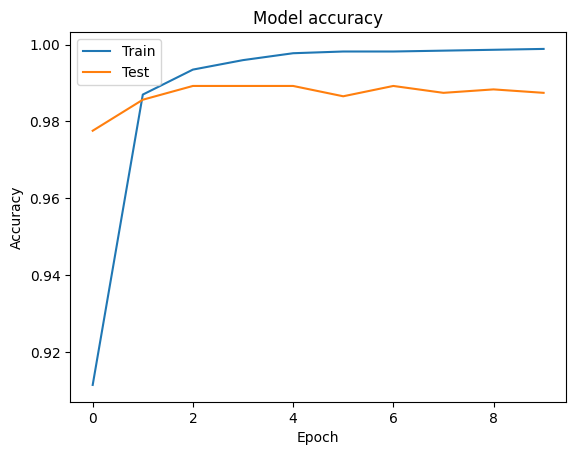

In [18]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from google.colab import files
files.download('spam_classifier.h5')
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import json
config = model.get_config()
with open('spam_classifier_config.json', 'w') as f:
    json.dump(config, f)

In [20]:
import joblib
from sklearn.linear_model import LogisticRegression

# Assuming you have a trained model
# Example:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = LogisticRegression()
# model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(model, 'spam_classifier_model.pkl')

['spam_classifier_model.pkl']

In [21]:
# Save the model weights
model.save_weights('spam_classifier_weights.h5')

In [22]:
import tensorflow as tf
print(tf.__version__)


2.15.0
